In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf
from tensorflow.keras.backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0



In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
import pickle
import cv2

In [4]:
EPOCHS = 1000
BATCH_SIZE = 16
IM_Z = 448
saved_path = "saved_models/model.h5"

In [5]:
with open('data.pickle', 'rb') as handle:
    [X_list_train, X_list_test, y_train, y_test] = pickle.load(handle)

In [6]:
X_list_train, X_list_valid, y_train, y_valid = train_test_split(X_list_train, y_train, test_size=0.2, stratify=y_train, random_state=7777777)

In [7]:
def decode_image(filename, label=None, image_size=(IM_Z, IM_Z)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_list_train)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_list_valid)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_reverse(x):
    return np.log(x / (1 - x))

In [10]:
def custom_regularizer(weights):
    return 10000. * tf.reduce_sum(tf.subtract(tf.abs(weights), weights))

backbone = tf.keras.applications.ResNet50(
    input_shape=(IM_Z, IM_Z, 3), 
    weights='imagenet', 
    include_top=False
)
gavp = tf.keras.layers.GlobalAveragePooling2D()(backbone.output)
logit = tf.keras.layers.Dense(
    1, 
    use_bias=False, 
    kernel_initializer=tf.keras.initializers.truncated_normal(mean=0.05, stddev=0.01), 
    kernel_regularizer=custom_regularizer
)(gavp)
output_tensor = tf.nn.sigmoid(tf.add(logit, tf.constant(-5.)))

model = tf.keras.Model(inputs=backbone.input, outputs=output_tensor)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.load_weights(saved_path)

In [12]:
def performance(a, b):
    print('acc: ', accuracy_score(a, b))
    print('pre: ', precision_score(a, b))
    print('rec: ', recall_score(a, b))
    print('f1s: ', f1_score(a, b))

In [13]:
prob_train = model.predict(train_dataset, verbose=1)

58/58 [==============================] - 12s 208ms/step


In [14]:
pred_train = np.round(prob_train)
performance(y_train, pred_train)

acc:  1.0
pre:  1.0
rec:  1.0
f1s:  1.0


In [15]:
prob_valid = model.predict(valid_dataset, verbose=1)

15/15 [==============================] - 5s 342ms/step


In [16]:
pred_valid = np.round(prob_valid)
performance(y_valid, pred_valid)

acc:  1.0
pre:  1.0
rec:  1.0
f1s:  1.0


In [18]:
weights = model.get_layer('dense').get_weights()[0]
FEATUREMAP = tf.keras.Model(inputs=model.input, outputs=model.get_layer('conv5_block3_out').output)
GAVP = tf.keras.Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)

In [19]:
def cam_process(cam):
    cam = cam.copy()
    max_scaler = 2.0
    cam[cam > 0] /= max_scaler
    cam[cam < 0] /= max_scaler
    return cam

In [22]:
def visualization(img):
    fmap = FEATUREMAP.predict(np.expand_dims(img, 0))
    fmap = fmap / 196
    fmap = np.squeeze(fmap)
    for i in range(2048):
        fmap[:, :, i] *= weights[i]

    cam = np.sum(fmap, axis=-1)
    cam = cv2.resize(cam, (IM_Z, IM_Z))
    
    gavp = GAVP.predict(np.expand_dims(img, 0))
    activations = np.multiply(np.squeeze(gavp), np.squeeze(weights))

    pos_logit = activations[activations > 0].sum()
    neg_logit = activations[activations < 0].sum()
    
    plt.figure(figsize=(20,10))
    plt.subplot(141)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(img)
    plt.imshow(cam_process(cam), alpha=0.5, cmap='jet', vmin=-1., vmax=1.)
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(img)
    cam2 = cam.copy()
    cam2[cam2 < 0] = 0
    plt.imshow(cam_process(cam2), alpha=0.5, cmap='jet', vmin=-1., vmax=1.)
    plt.title(pos_logit, fontsize=20)
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(img)
    cam2 = cam.copy()
    cam2[cam2 > 0] = 0
    plt.imshow(cam_process(cam2), alpha=0.5, cmap='jet', vmin=-1., vmax=1.)
    plt.title(neg_logit, fontsize=20)
    plt.axis('off')
    plt.show()

In [23]:
img = cv2.resize(cv2.imread(X_list_valid[224])[:,:,::-1], (IM_Z, IM_Z)) / 255.

In [24]:
pred = model.predict(np.expand_dims(img, 0))
pred

array([[0.00981703]], dtype=float32)

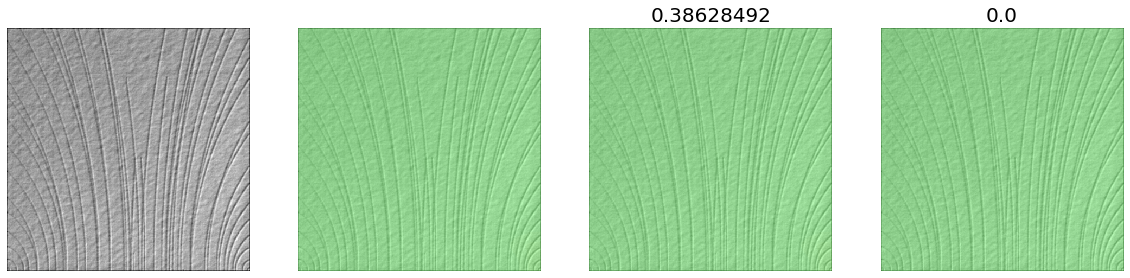

In [25]:
visualization(img)

In [28]:
img = cv2.resize(cv2.imread(X_list_valid[12])[:,:,::-1], (IM_Z, IM_Z)) / 255.

In [29]:
pred = model.predict(np.expand_dims(img, 0))
pred

array([[1.]], dtype=float32)

In [36]:
img = cv2.resize(cv2.imread('fake.jpg')[:,:,::-1], (IM_Z, IM_Z)) / 255.

In [37]:
pred = model.predict(np.expand_dims(img, 0))
pred

array([[0.99989355]], dtype=float32)

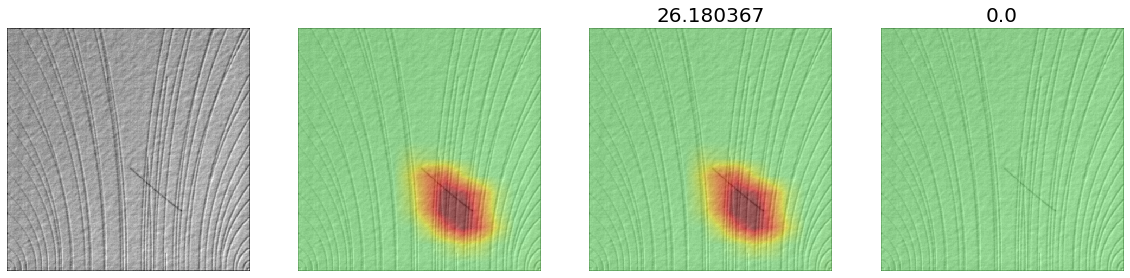

In [30]:
visualization(img)

In [31]:
img = cv2.resize(cv2.imread('fake.jpg')[:,:,::-1], (IM_Z, IM_Z)) / 255.

In [32]:
pred = model.predict(np.expand_dims(img, 0))
pred

array([[0.998675]], dtype=float32)

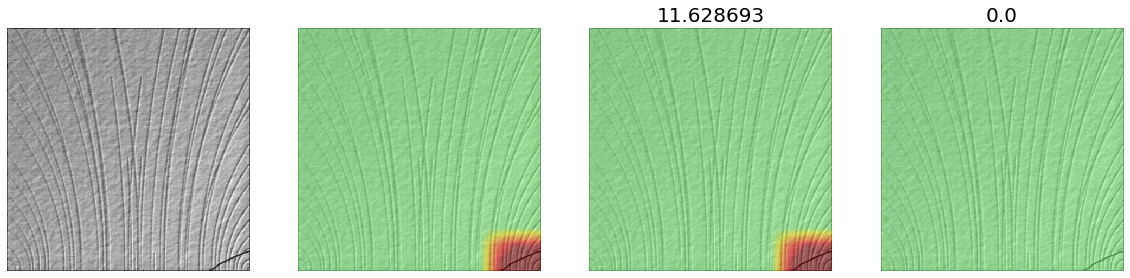

In [33]:
visualization(img)